Kuo Yang, Lab 9, 12/13/25  
CS 121/Python DSML  
East Los Angeles College, FA 2025

***
Data prep same as Lab 9, New starting line 179.
***

Question: Looks like I needed to scale/normalize my data due to the differences in numerical scale between weight and age. I used a standard scaler which normalizes to a mean=0 and SD=1. Does that look about right? Any comments? (I need to lookup what's the norm for biomedical datasets in ML. Previously, I've only normalized/centered to the mean, haven't gone as far as getting the mean to zero and SD to 1.)

Only complication I can think of while doing this type of normalization is that there may be issues in the future with division by zero or log/ln?

In [230]:
#basic libs
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
#import seaborn as sns

#trees
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression

#Kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## 1: Creating and exploring pandas data series

In [231]:
glp1=pd.read_csv('glp1df.csv') #not sure why, but if I include encoding='latin1' I lose some data in api1 column
print(glp1.shape)

(300554, 25)


In [232]:
glp1.head()

,Case ID,Suspect Product Names,Suspect Product Active Ingredients,Reason for Use,Reactions,Serious,Outcomes,Sex,Event Date,Latest FDA Received Date,...,Report Source,Concomitant Product Names,Latest Manufacturer Received Date,Initial FDA Received Date,Country where Event occurred,Reported to Manufacturer?,Manufacturer Control Number,Literature Reference,Compounded Flag,api1
0,25142581,Trulicity,Dulaglutide,Product Used For Unknown Indication,Injection Site Pain,Non-Serious,Non-Serious,Male,-,31-MAR-2025,...,Not Specified,-,24-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503021448,-,-,1
1,25142580,Trulicity,Dulaglutide,Type 2 Diabetes Mellitus,Visual Impairment;Product Storage Error,Non-Serious,Non-Serious,Female,-,31-MAR-2025,...,Not Specified,-,24-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503021444,-,-,1
2,25141349,Trulicity,Dulaglutide,Product Used For Unknown Indication,Inappropriate Schedule Of Product Administrati...,Non-Serious,Non-Serious,Male,25-MAR-2025,31-MAR-2025,...,Not Specified,-,28-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503025775,-,-,1
3,25140677,Trulicity,Dulaglutide,Type 2 Diabetes Mellitus,Depression;Decreased Appetite;Schizophrenia;Ma...,Serious,Hospitalized,Female,DEC-2024,31-MAR-2025,...,Not Specified,-,25-MAR-2025,31-MAR-2025,JP,Not Specified,JP-ELI_LILLY_AND_COMPANY-JP202503002636,-,-,1
4,25140673,Trulicity,Dulaglutide,Product Used For Unknown Indication,Paraesthesia,Non-Serious,Non-Serious,Female,-,31-MAR-2025,...,Not Specified,-,27-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503024471,-,-,1


In [233]:
glp1.columns

Index(['Case ID', 'Suspect Product Names',
       'Suspect Product Active Ingredients', 'Reason for Use', 'Reactions',
       'Serious', 'Outcomes', 'Sex', 'Event Date', 'Latest FDA Received Date',
       'Case Priority', 'Patient Age', 'Patient Weight', 'Sender',
       'Reporter Type', 'Report Source', 'Concomitant Product Names',
       'Latest Manufacturer Received Date', 'Initial FDA Received Date',
       'Country where Event occurred', 'Reported to Manufacturer?',
       'Manufacturer Control Number', 'Literature Reference',
       'Compounded Flag', 'api1'],
      dtype='object')

### <span style="color:red;">Standardizing Year. (Courtesy of Ramirez,J of ELAC) </span>


In [234]:

UNIT_MAP = {
    'yr': 'year', 'yrs': 'year', 'y': 'year', 'year': 'year', 'years': 'year',
    'day': 'day', 'days': 'day', 'd': 'day',
    'week': 'week', 'weeks': 'week', 'wk': 'week', 'wks': 'week',
    'mth': 'month', 'mon': 'month', 'month': 'month', 'months': 'month', 'mo': 'month',
    'dec': 'decade', 'decade': 'decade', 'decades': 'decade'
}

In [235]:
import re

def parse_age_to_years(val):
    # handle missing/unknown
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    if s in ('', 'nan', 'none', 'not specified', 'unknown'):
        return np.nan

    # grab first number (allow decimals)
    mnum = re.search(r'(\d+(\.\d+)?)', s)
    if not mnum:
        return np.nan
    num = float(mnum.group(1))

    # find a recognizable unit token, prefer the last token in the string
    toks = re.findall(r'[a-z]+', s)
    unit_std = None
    for tok in reversed(toks):
        if tok in UNIT_MAP:
            unit_std = UNIT_MAP[tok]
            break

    # convert to years
    if unit_std in (None, 'year'):
        years = num
    elif unit_std == 'month':
        years = num / 12.0
    elif unit_std == 'week':
        years = num / 52.0
    elif unit_std == 'day':
        years = num / 365.0
    elif unit_std == 'decade':
        years = num * 10.0
    else:
        years = np.nan

    return years

### <span style="color:red;">Age_Years (Courtesy of Ramirez,J, ELAC) </span>


In [236]:
glp1['Age_Years'] = glp1['Patient Age'].apply(parse_age_to_years)
print(glp1[['Patient Age', 'Age_Years']])


       Patient Age  Age_Years
0            80 YR       80.0
1            80 YR       80.0
2            85 YR       85.0
3            71 YR       71.0
4            63 YR       63.0
...            ...        ...
300549       55 YR       55.0
300550       32 YR       32.0
300551       49 YR       49.0
300552       74 YR       74.0
300553       32 YR       32.0

[300554 rows x 2 columns]


Age and Weight Clean

In [237]:
glp1['Weight1']=pd.to_numeric(glp1['Patient Weight'].str.replace('[^\\d.]','',regex=True),errors='coerce')

#filter in age between 0 and 150, weight <300kg
glp1_2=glp1.query('Age_Years > 0 & Age_Years < 150 & Weight1 < 300').copy()
print(glp1_2)

         Case ID Suspect Product Names Suspect Product Active Ingredients  \
7       25139513     Trulicity;Ozempic            Semaglutide;Dulaglutide   
12      25138398     Trulicity;Humalog         Insulin Lispro;Dulaglutide   
18      25138045     Humalog;Trulicity         Dulaglutide;Insulin Lispro   
49      24970509             Trulicity                        Dulaglutide   
50      24798740             Trulicity                        Dulaglutide   
...          ...                   ...                                ...   
300549  24904201                     -             Pyridoxine\Tirzepatide   
300550  24642147                     -             Pyridoxine\Tirzepatide   
300551  24398076                     -             Pyridoxine\Tirzepatide   
300552  24327525                     -             Pyridoxine\Tirzepatide   
300553  24129001                     -            Niacinamide\Tirzepatide   

                                           Reason for Use  \
7       Blood 

###Compounded Data Map (new column: CMPD)

In [238]:
glp1_2['Compounded Flag'].unique()

array(['-', 'Yes'], dtype=object)

In [239]:
#create column cmpd, where 1=yes, 2=no (-)
glp1_2['CMPD'] = glp1_2['Compounded Flag'].map({'Yes': 1, '-': 0})

In [240]:
glp1_2.head()

,Case ID,Suspect Product Names,Suspect Product Active Ingredients,Reason for Use,Reactions,Serious,Outcomes,Sex,Event Date,Latest FDA Received Date,...,Initial FDA Received Date,Country where Event occurred,Reported to Manufacturer?,Manufacturer Control Number,Literature Reference,Compounded Flag,api1,Age_Years,Weight1,CMPD
7,25139513,Trulicity;Ozempic,Semaglutide;Dulaglutide,Blood Cholesterol Increased;Gastrooesophageal ...,Decreased Appetite;Impaired Gastric Emptying,Serious,Other Outcomes;Hospitalized,Female,01-DEC-2022,31-MAR-2025,...,31-MAR-2025,US,Not Specified,US-NOVOPROD-1319160,-,-,1,44.0,79.365,0
12,25138398,Trulicity;Humalog,Insulin Lispro;Dulaglutide,Product Used For Unknown Indication,Haemorrhage,Non-Serious,Non-Serious,Female,09-MAR-2025,30-MAR-2025,...,30-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503022358,-,-,1,89.0,86.168,0
18,25138045,Humalog;Trulicity,Dulaglutide;Insulin Lispro,Product Used For Unknown Indication,Haemorrhage,Non-Serious,Non-Serious,Female,18-MAR-2025,29-MAR-2025,...,29-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503021035,-,-,1,62.0,77.564,0
49,24970509,Trulicity,Dulaglutide,Type 2 Diabetes Mellitus,Nausea;Dyspepsia;Decreased Appetite;Diarrhoea;...,Serious,Other Outcomes,Female,01-APR-2022,27-MAR-2025,...,14-FEB-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202502002666,-,-,1,41.0,136.050,0
50,24798740,Trulicity,Dulaglutide,Asthma;Deep Vein Thrombosis;Depression;Diabete...,Vomiting;Nausea;Diarrhoea;Constipation;Abdomin...,Serious,Hospitalized;Other Outcomes,Female,08-SEP-2022,27-MAR-2025,...,02-JAN-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202412018435,-,-,1,69.0,150.000,0


In [241]:
#Sex2
glp1_2['Sex2'] = glp1_2['Sex'].map({'Female': 1, 'Male': 0})
#Serious2
glp1_2['Serious2'] = glp1_2['Serious'].map({'Serious': 1, 'Non-Serious': 0})

In [242]:
glp1_2.head()

,Case ID,Suspect Product Names,Suspect Product Active Ingredients,Reason for Use,Reactions,Serious,Outcomes,Sex,Event Date,Latest FDA Received Date,...,Reported to Manufacturer?,Manufacturer Control Number,Literature Reference,Compounded Flag,api1,Age_Years,Weight1,CMPD,Sex2,Serious2
7,25139513,Trulicity;Ozempic,Semaglutide;Dulaglutide,Blood Cholesterol Increased;Gastrooesophageal ...,Decreased Appetite;Impaired Gastric Emptying,Serious,Other Outcomes;Hospitalized,Female,01-DEC-2022,31-MAR-2025,...,Not Specified,US-NOVOPROD-1319160,-,-,1,44.0,79.365,0,1.0,1
12,25138398,Trulicity;Humalog,Insulin Lispro;Dulaglutide,Product Used For Unknown Indication,Haemorrhage,Non-Serious,Non-Serious,Female,09-MAR-2025,30-MAR-2025,...,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503022358,-,-,1,89.0,86.168,0,1.0,0
18,25138045,Humalog;Trulicity,Dulaglutide;Insulin Lispro,Product Used For Unknown Indication,Haemorrhage,Non-Serious,Non-Serious,Female,18-MAR-2025,29-MAR-2025,...,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503021035,-,-,1,62.0,77.564,0,1.0,0
49,24970509,Trulicity,Dulaglutide,Type 2 Diabetes Mellitus,Nausea;Dyspepsia;Decreased Appetite;Diarrhoea;...,Serious,Other Outcomes,Female,01-APR-2022,27-MAR-2025,...,Not Specified,US-ELI_LILLY_AND_COMPANY-US202502002666,-,-,1,41.0,136.050,0,1.0,1
50,24798740,Trulicity,Dulaglutide,Asthma;Deep Vein Thrombosis;Depression;Diabete...,Vomiting;Nausea;Diarrhoea;Constipation;Abdomin...,Serious,Hospitalized;Other Outcomes,Female,08-SEP-2022,27-MAR-2025,...,Not Specified,US-ELI_LILLY_AND_COMPANY-US202412018435,-,-,1,69.0,150.000,0,1.0,1


In [243]:
#api1
print(glp1_2['api1'].dtype)

int64


End of Datasetup (Use glp1_2)

---
Start Clustering

## K-Means Clustering

In [244]:
X = glp1_2[["Age_Years",'Weight1']][glp1_2['Serious2'] == 1].copy()
X2 = X.dropna()
X2.head()

,Age_Years,Weight1
7,44.0,79.365
49,41.0,136.050
50,69.0,150.000
51,82.0,71.200
67,41.0,93.000


In [245]:
inertia_vals = []
k_values = range(1, 10)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X2)
    inertia_vals.append(km.inertia_)

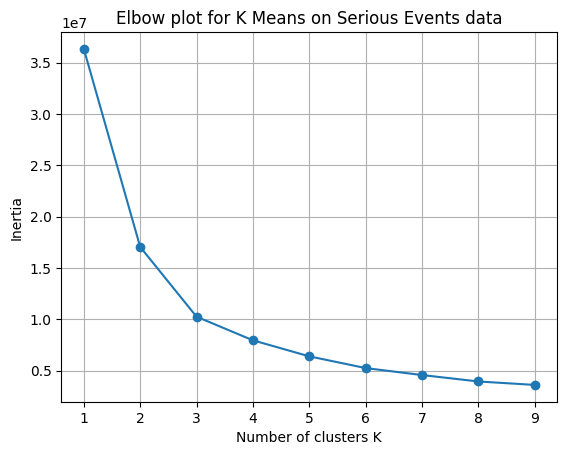

In [246]:
plt.figure()
plt.plot(k_values, inertia_vals, marker="o")
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia")
plt.title("Elbow plot for K Means on Serious Events data")
plt.grid(True)
plt.show()

It looks like the elbow point might be around 3 or 4, so try Cluster=3 first.

In [247]:
kmeans = KMeans(n_clusters=3, random_state=42)
X2["cluster"] = kmeans.fit_predict(X2)
X2

,Age_Years,Weight1,cluster
7,44.0,79.365,1
49,41.0,136.050,2
50,69.0,150.000,2
51,82.0,71.200,1
67,41.0,93.000,1
...,...,...,...
300548,73.0,72.000,1
300549,55.0,67.500,1
300550,32.0,92.250,1
300551,49.0,62.550,1


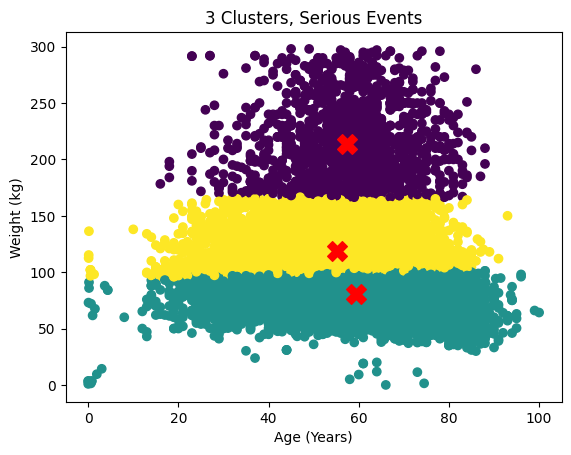

In [248]:
plt.scatter(X2["Age_Years"], X2["Weight1"], c=X2["cluster"])
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c="red", s=200, marker="X")
plt.xlabel("Age (Years)")
plt.ylabel("Weight (kg)")
plt.title("3 Clusters, Serious Events")
plt.show()

This doesn't look right, looks like it's grouping only by weight? Need to center/normalize data to zero. (Weight runs from 0 - 300, which dwarfs age (0-100))

###Center Data around 0

In [249]:
#reset X2
X2 = glp1_2[["Age_Years",'Weight1']][glp1_2['Serious2'] == 1].copy()
X2 = X2.dropna()
X2.head()

,Age_Years,Weight1
7,44.0,79.365
49,41.0,136.050
50,69.0,150.000
51,82.0,71.200
67,41.0,93.000


In [250]:
#Center/Scale to mean=0, SD=1
scaler = StandardScaler()
X3 = scaler.fit_transform(X2)
print(X3)

[[-1.03016455 -0.60991033]
 [-1.25440037  0.93758415]
 [ 0.83846726  1.31841766]
 ...
 [-1.92710783 -0.2581512 ]
 [-0.65643819 -1.06895804]
 [-1.92710783 -0.22129634]]


Did I do this right?? StandardScaler fxn from sklearn.preprocessing

###Elbow Plot with Scaled Data

In [251]:
inertia_vals = []
k_values = range(1, 10)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X3)
    inertia_vals.append(km.inertia_)

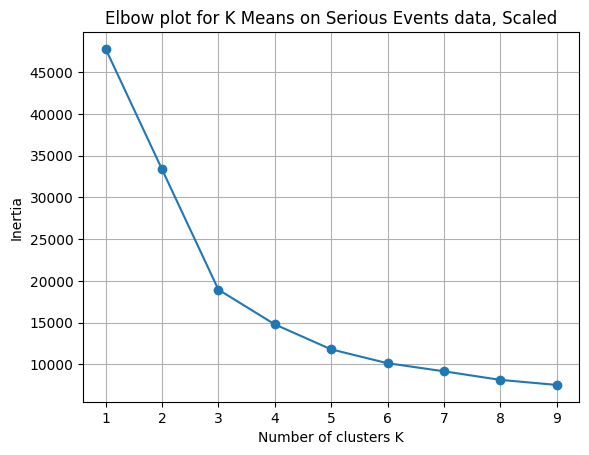

In [252]:
plt.figure()
plt.plot(k_values, inertia_vals, marker="o")
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia")
plt.title("Elbow plot for K Means on Serious Events data, Scaled")
plt.grid(True)
plt.show()

It looks like elbow's around 3 or 4, then it starts to level out.

###Cluster = 3, Scaled

In [253]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit_predict(X3)

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [254]:
X2['cluster'] = kmeans.labels_
X2.head()

,Age_Years,Weight1,cluster
7,44.0,79.365,1
49,41.0,136.050,1
50,69.0,150.000,0
51,82.0,71.200,2
67,41.0,93.000,1


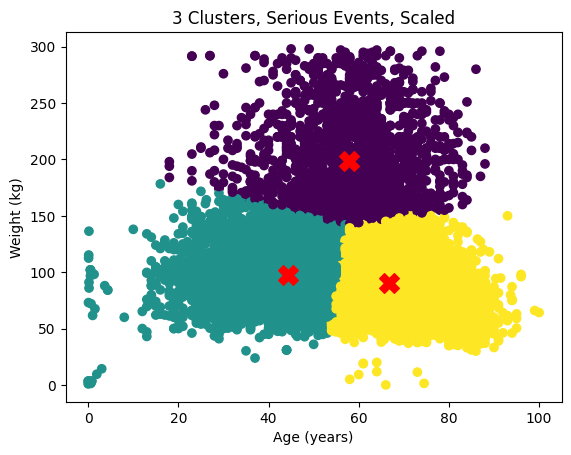

In [255]:
plt.scatter(X2["Age_Years"], X2["Weight1"], c=X2["cluster"])
centers = kmeans.cluster_centers_
centers2 = scaler.inverse_transform(centers)
plt.scatter(centers2[:, 0], centers2[:, 1], c="red", s=200, marker="X")
plt.xlabel("Age (years)")
plt.ylabel("Weight (kg)")
plt.title("3 Clusters, Serious Events, Scaled")
plt.show()

It looks like weight >~150kg is one group, then within the <150kg is divided into two subgroups, the older and younger, with cutoff at around 50.

In [256]:
centers3 = pd.DataFrame(centers2, columns=['Age', 'Weight'])
print('Cluster Centers\n',centers3)

Cluster Centers
          Age      Weight
0  57.772668  198.415536
1  44.358311   97.614579
2  66.608514   90.836908


###Cluster = 4, Scaled

In [257]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit_predict(X3)

array([1, 1, 3, ..., 1, 3, 1], dtype=int32)

In [258]:
X2['Cluster'] = kmeans.labels_
X2.head()

,Age_Years,Weight1,cluster,Cluster
7,44.0,79.365,1,1
49,41.0,136.050,1,1
50,69.0,150.000,0,3
51,82.0,71.200,2,2
67,41.0,93.000,1,1


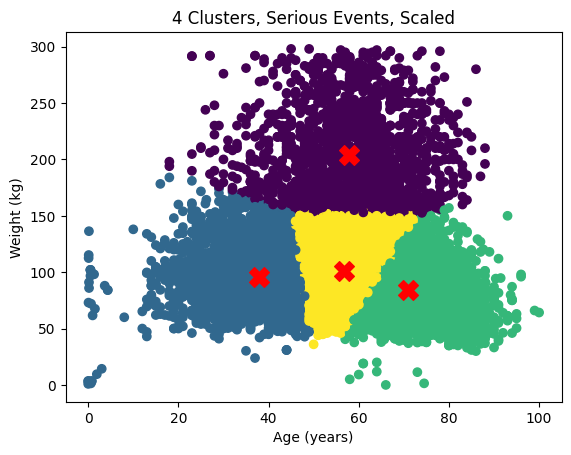

In [259]:
plt.scatter(X2["Age_Years"], X2["Weight1"], c=X2["Cluster"])
centers = kmeans.cluster_centers_
centers2 = scaler.inverse_transform(centers)
plt.scatter(centers2[:, 0], centers2[:, 1], c="red", s=200, marker="X")
plt.xlabel("Age (years)")
plt.ylabel("Weight (kg)")
plt.title("4 Clusters, Serious Events, Scaled")
plt.show()

This is interesting - when I added another cluster, it just adds another subgroup to the <150kg, further subdiving the ages into 3 groups: <~45, <~65, and older.

In [260]:
centers3 = pd.DataFrame(centers2, columns=['Age', 'Weight'])
print('Cluster Centers\n',centers3)

Cluster Centers
          Age      Weight
0  57.811439  204.047153
1  37.899424   95.553204
2  71.017409   84.450662
3  56.820123  100.921439


## Conclusions

In this exercise, I tried to see if there are subgroups within the serious events. For example, perhaps there is a high risk group (e.g. age>80, weight>200kg, etc...). From the subgroup analysis, it looks like there are 4 groups, with two main groups: the heavy (centered around 204kg) and light weight. Within the light weight, it's further divided by age centered around 38, 57, and 71. I think what this says is that after initial division by weight (heavy from light), age is the remaining important discriminator. This kind of makes sense, because weight, without height to calculate BMI, doesn't say much about someone's health. For instance, someone >150kg is most likely obese, regardless of height (unless this person is extraordinarily tall!), while someone ~100kg, without height information, could be healthy, overweight, or obese - doesn't really say much. Age, on the other hand, contains information on its own about someone's frailty. e.g. a younger person less than 30 probably has a distinct phenotype (young, high metabolism, mobile and ambulatory) from someone >60 (older and frail).


4 Groups:
1.   Heavy Weight (Center: 204 kg, 58 years)
2.   Light Weight, young (Center: 96 kg, 38 years)
3.   Light Weight, old (Center: 84 kg, 71 Years)
4.  Light Weight, middle age (Center: 101 kg, 57 Years)



One interesting side note about scaling data - I've never scaled data this aggressively before. I've scaled height/weight/creatinine clearance (renal fxn) to the mean, that's about it, I've never scaled it to a mean=0 and even the shape (SD). Did I do it right?

## Testing/scratch Area

Caveats:
* No rate information can be inferred without total Rx dispensed
* Correlation is not causation

Disclaimer:
Please note that this was developed for academic coursework, and is intended for educational purposes ONLY. The information provided does NOT imply causation, safety, or efficacy. This is not medical advice and should not be used to diagnose, treat, cure, or prevent any disease. Always consult a qualified healthcare professional for any health-related concerns. No guarantees are made regarding the completeness, accuracy, or timeliness of the information provided. Full disclaimer: (https://www.fda.gov/drugs/fdas-adverse-event-reporting-system-faers/fda-adverse-event-reporting-system-faers-public-dashboard)